# Notebook pour le projet d'optimisation bi-objectif sur le stockage embarqué dans un tramway

#### Groupe : 
- Walid Abdelaziz KHODJA (21214724)
- Manel MOULAHCENE (21122033)
-  Hadriel RATIARISON (21109195)

## 1.Introduction 
Ce projet s'inscrit dans le cadre de l'optimisation bi-objectif appliquée au dimensionnement d'un système 
d'alimentation hybride pour un tramway. Le système étudié combine une ligne aérienne de contact (LAC) 
et une batterie embarquée pour améliorer les performances énergétiques et réduire les contraintes sur le réseau.

### Objectifs principaux :
1. Minimiser la capacité de la batterie, directement liée au coût du système.
2. Réduire la chute de tension maximale aux bornes du train, un indicateur clé de la robustesse du réseau d'alimentation.

### Contexte :
Lors des phases de freinage, une partie de l'énergie mécanique peut être récupérée grâce à une batterie embarquée. 
Cette énergie stockée est ensuite réutilisée pour alimenter le train lors des phases de traction, 
permettant ainsi de réduire les appels de puissance sur la ligne aérienne de contact. 
Cependant, le dimensionnement optimal de cette batterie et la mise en place d'une stratégie de gestion efficace 
sont des défis complexes nécessitant des approches avancées telles que la simulation et l'optimisation multi-critères.

### Plan du Notebook :
1. Simulation de la ligne de tramway sans batterie pour établir une base de référence.
2. Ajout et simulation d'un système de stockage pour observer ses impacts.
3. Mise en œuvre de méthodes d'optimisation (Monte Carlo et NSGA-II) pour identifier les solutions optimales.
4. Analyse et interprétation des résultats obtenus.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from Functions import *

## 2.Mise en place du modèle du système 

Modèle électrique du système quand le train est à la position x : 

![Modèle électrique du système quand le train est à la position x](Model.png)

### 2.1.Mise en place sans système de stockage


Extraction des données du fichier 

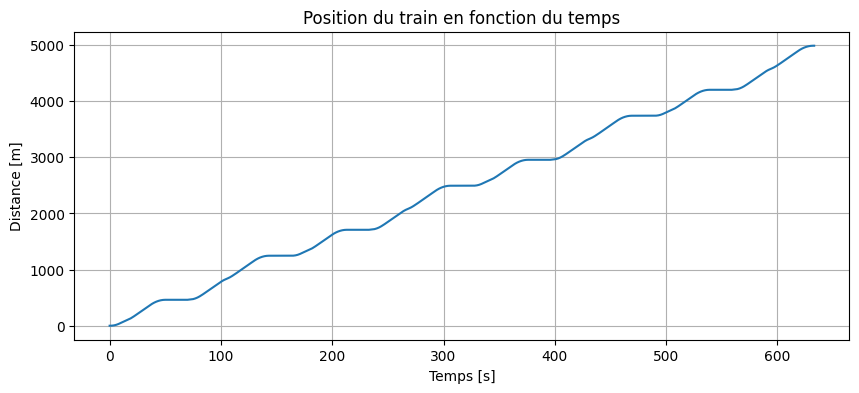

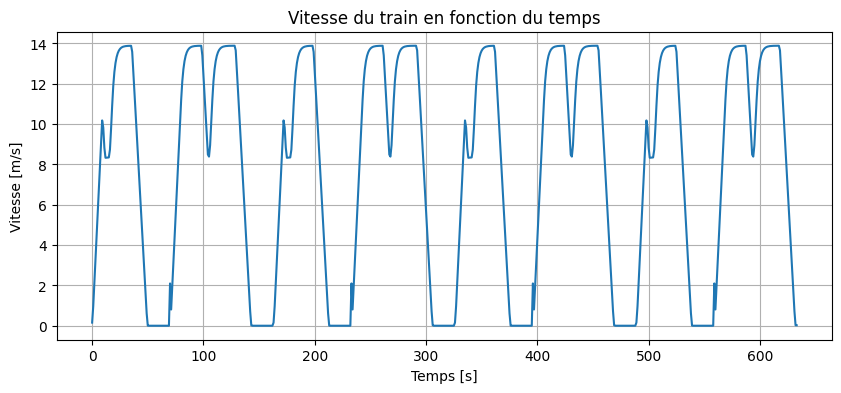

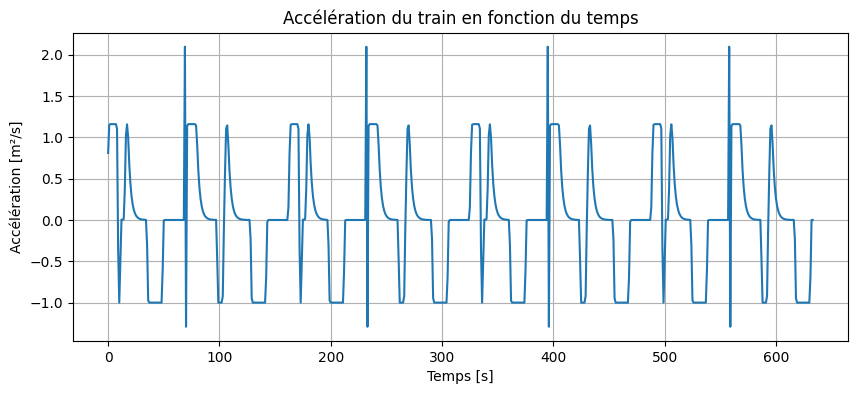

In [2]:
# Ouvrir le fichier en mode lecture
with open("marche.txt", "r") as f:
    data = f.readlines()  # Lire toutes les lignes du fichier dans une liste

# **Étape 2 : Pré-traitement des données**
# Supprimer les sauts de ligne et séparer les colonnes par tabulation ('\t')
data = [ligne.strip().split('\t') for ligne in data]

# Extraction des vecteurs temps et position
temps = [t[0] for t in data]  # Première colonne : temps
position = [x[1] for x in data]  # Deuxième colonne : position

# Conversion des vecteurs en types numériques et stockage dans des tableaux NumPy
position = np.array(list(map(float, position)))  # Position en flottant
temps = np.array(list(map(int, temps)))  # Temps en entier

# **Étape 3 : Calcul des dérivées**
# Calcul de la vitesse par différenciation de la position
vitesse = [position[i + 1] - position[i] for i in range(len(position) - 1)]  # Différence successive
vitesse.append(vitesse[-1])  # Réguler la taille du vecteur (ajouter le dernier élément)
vitesse = np.array(vitesse)  # Conversion en tableau NumPy

# Calcul de l'accélération par différenciation de la vitesse
acc = [vitesse[i + 1] - vitesse[i] for i in range(len(vitesse) - 1)]  # Différence successive
acc.append(acc[-1])  # Réguler la taille du vecteur (ajouter le dernier élément)
acc = np.array(acc)  # Conversion en tableau NumPy

# **Étape 4 : Visualisation des données**
# Position en fonction du temps
plt.figure(figsize=(10, 4))
plt.plot(temps, position)
plt.xlabel('Temps [s]')
plt.ylabel('Distance [m]')
plt.title("Position du train en fonction du temps")
plt.grid()
plt.show()

# Vitesse en fonction du temps
plt.figure(figsize=(10, 4))
plt.plot(temps, vitesse)
plt.xlabel('Temps [s]')
plt.ylabel('Vitesse [m/s]')
plt.title("Vitesse du train en fonction du temps")
plt.grid()
plt.show()

# Accélération en fonction du temps
plt.figure(figsize=(10, 4))
plt.plot(temps, acc)
plt.xlabel('Temps [s]')
plt.ylabel('Accélération [m²/s]')
plt.title("Accélération du train en fonction du temps")
plt.grid()
plt.show()



Calcul de la puissance consommée par le train en utilisant les différentes formules données dans l'énnoncé 

#### 2.1.1Calcul de la puissance consommée par le train en utilisant les différentes formules données dans l'énnoncé:

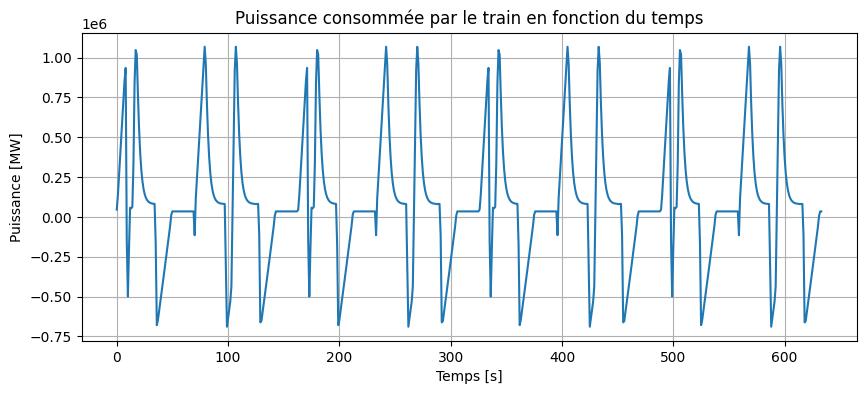

In [3]:
# **Constantes**
M = 70 * 1000  # Masse totale en kg (conversion tonne -> kg)
A0 = 780  # Terme constant de la force de roulement
A1 = 6.4 / 1000  # Terme proportionnel à la masse (conversion tonne -> kg)
B0 = 0  # Terme constant de la résistance aérodynamique
B1 = 3.6 * 0.14 / 1000  # Terme proportionnel à la masse (conversion tonne -> kg et km/h -> m/s)
C0 = 0.3634 * (3.6)**2  # Terme quadratique (conversion km/h -> m/s)
C1 = 0  # Terme proportionnel à la masse pour le terme quadratique
rend = 0.8  # Rendement de conversion mécanique/électrique

# **Calcul de la force motrice**
# Force de roulement (Fr)
Fr = (A0 + A1 * M) + (B0 + B1 * M) * vitesse + (C0 + C1 * M) * vitesse**2

# Force motrice totale (Fmot)
Fmot = M * acc + Fr

# **Calcul de la puissance**
# Puissance mécanique (Pmec)
Pmec = Fmot * vitesse

# Puissance électrique (Pelec) avec prise en compte du rendement
Pelec = np.array([Pmec[i] / rend if Pmec[i] >= 0 else Pmec[i] * rend for i in range(len(vitesse))])

# Ajout de la puissance constante (ex. consommation auxiliaire)
Ptrain = Pelec + 35 * 1000  # Puissance totale consommée par le train

# **Visualisation**
plt.figure(figsize=(10, 4))
plt.plot(temps, Ptrain)
plt.title("Puissance consommée par le train en fonction du temps")
plt.xlabel('Temps [s]')
plt.ylabel('Puissance [MW]')
plt.grid()
plt.show()


#### 2.1.2.Calcul de la chute de la tension aux bornes du train afin de déduire la chute de tension 

C:\Users\khodj\AppData\Local\Temp\ipykernel_25780\315269059.py:19: RuntimeWarning: invalid value encountered in sqrt
  Vtrain = 0.5 * Vsst + 0.5 * np.sqrt(Vsst**2 - 4 * Req * Ptrain)


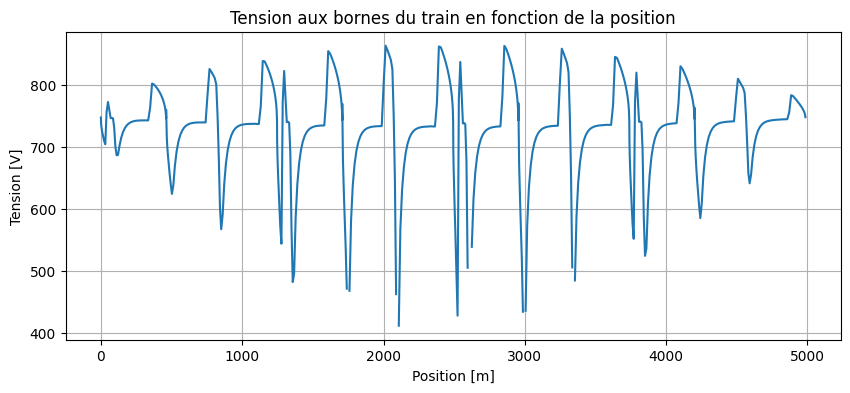

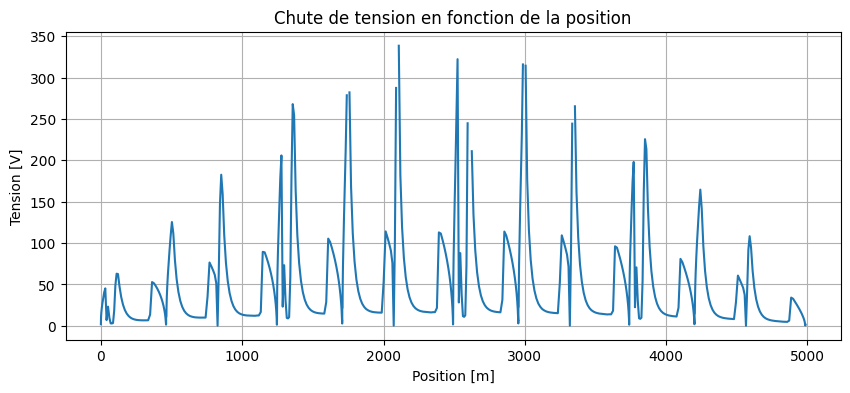

In [4]:
# **Constantes**
Rsst = 33e-3  # Résistance de la sous-station (ohms)
rolac = 95e-6  # Résistance linéique de la ligne aérienne de contact (ohms/m)
rorail = 10e-6  # Résistance linéique du rail (ohms/m)

# Calcul des résistances le long de la ligne et du rail
Rlac1 = rolac * position  # Résistance de la LAC entre la sous-station et le train
Rlac2 = rolac * (position[-1] - position)  # Résistance de la LAC après le train
Rrail1 = rorail * position  # Résistance du rail entre la sous-station et le train
Rrail2 = rorail * (position[-1] - position)  # Résistance du rail après le train

Vsst = 750  # Tension nominale de la sous-station (volts)

# **Calcul de la résistance équivalente**
Req = (Rsst + Rrail1 + Rlac1) * (Rsst + Rrail2 + Rlac2) / \
      (2 * Rsst + Rrail1 + Rlac1 + Rrail2 + Rlac2)

# **Calcul de la tension aux bornes du train**
Vtrain = 0.5 * Vsst + 0.5 * np.sqrt(Vsst**2 - 4 * Req * Ptrain)

# **Calcul de la chute de tension**
chute = np.array([abs(Vsst - v) for v in Vtrain])

# **Visualisation : Tension aux bornes du train**
plt.figure(figsize=(10, 4))
plt.plot(position, Vtrain)
plt.title('Tension aux bornes du train en fonction de la position')
plt.xlabel('Position [m]')
plt.ylabel('Tension [V]')
plt.grid()
plt.show()

# **Visualisation : Chute de tension**
plt.figure(figsize=(10, 4))
plt.plot(position, chute)
plt.title('Chute de tension en fonction de la position')
plt.xlabel('Position [m]')
plt.ylabel('Tension [V]')
plt.grid()
plt.show()


**Remarque :**
- Selon la représentation de la chute de tension, on remarque des discontinuités qui sont du au non respect de la valeur de Plac tel que : $P_{LAC} > \dfrac{V_{sst}^2}{4 R_{eq}}$ 
- On remarque ainsi une grande chute de tension (environ 360V) qui dépasse la limite autorisé de 100V au maximum. 
- Dans un second temps la batterie va intervenir afin de diminuer la cute de tension.

#### 2.1.3.Calcul et affichage de l'énergie du train à partir de l'intégration de la puissance déjà calculée en utilisant la méthode d'integgral de trapèze:

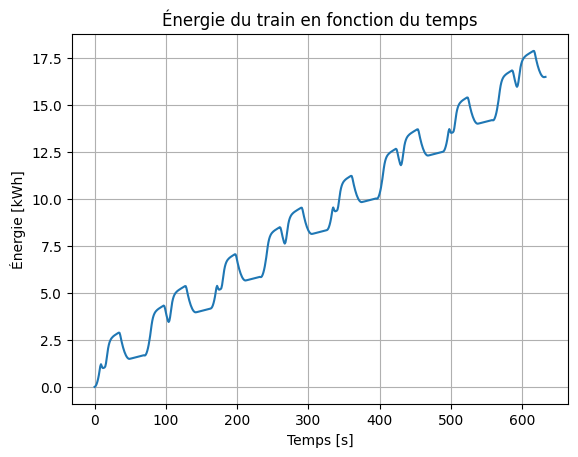

In [5]:
# **Calcul de l'intégrale cumulée avec la méthode des trapèzes**
# Calcul de l'énergie cumulée consommée par le train
Etrain = np.cumsum(np.diff(temps) * (Ptrain[:-1] + Ptrain[1:]) / 2)

# Ajouter un 0 initial pour que l'intégrale commence à 0
Etrain = np.insert(Etrain, 0, 0)

# **Visualisation : Énergie du train en fonction du temps**
plt.figure()
plt.plot(temps, Etrain * 1e-3 / 3600)  # Conversion en kWh
plt.title("Énergie du train en fonction du temps")
plt.xlabel('Temps [s]')
plt.ylabel('Énergie [kWh]')
plt.grid()
plt.show()

**Remarque** 
- On remarque une grande perte d'énergie durant le freinage à plusiieurs reprise, on va utiliser cette énergie perdue pour charger la batterie qui sera ajouter 

### 2.2.Mise en place avec système de stockage

Circuit simplifié  montrant le système train + batterie + rhéostat 

![Flux de puissance de l’alimentation hybride LAC/batterie](batterie.png)

#### 2.2.1.Test du bon fonctionnement de l'algorithme 
- Dans cette partie, une valeur approximative de la cappacité de la batterie est prise afin de tester le bon fonctionnement dee l'algorithme developpée dans le but de simuler le trjet du Tramway avec système de stockage 
- Cet algorithme sera mis dans ue fonction **simulation_sys**, située dans le fichier **Functions.py** afin de simplifier son utilisation dans les algorithmes génétiques  
- Un rendement de 90 % de la batterie signifie que seulement 90 % de l’énergie entrée ou disponible est utilisable sous forme d’énergie utile, tandis que les 10 % restants sont perdus sous forme de chaleur ou d'autres pertes internes (effet Joule, résistance interne, etc.).
- Charge de la batterie : Si 100 Wh d’énergie est fournis, avec un rendement de 90 %, la batterie n’emmagasinera que 90 Wh sous forme d’énergie utilisable.
- Décharge de la batterie : Lors de la décharge, si la batterie restitue cette énergie, que 90 % de l’énergie emmagasinée est récupérable, donc environ 81 Wh utilisables sur les 100 Wh initialement fournis.
 

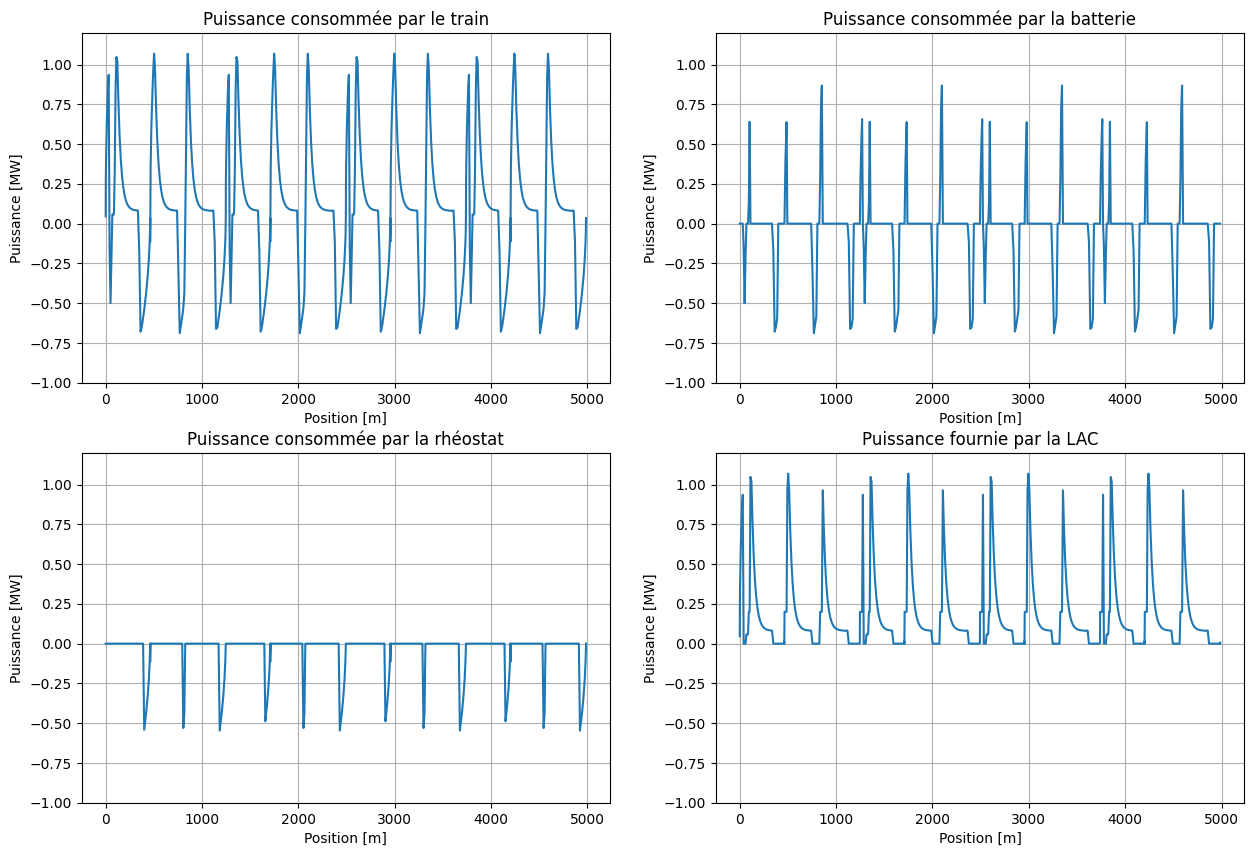

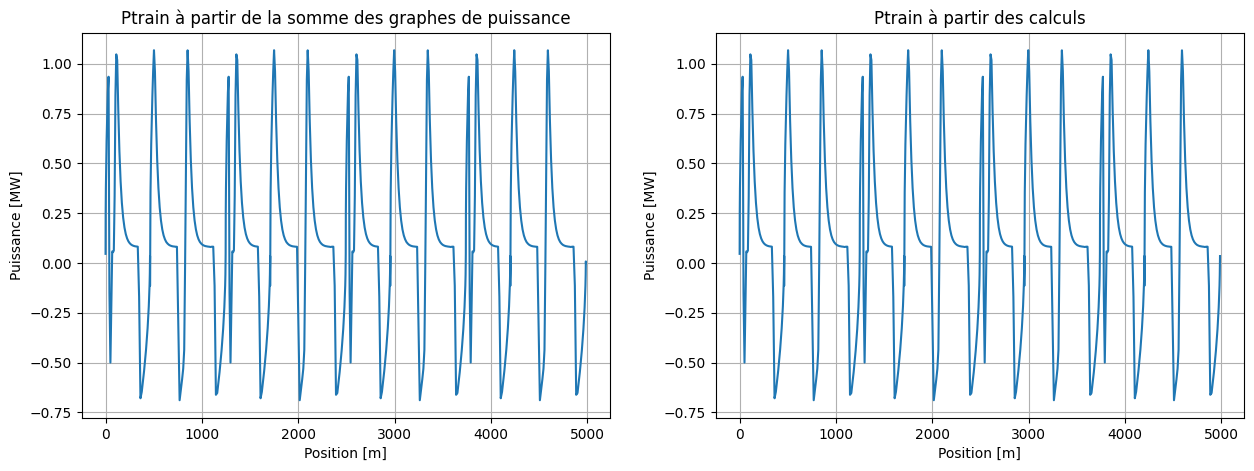

In [6]:
# **Initialisation des paramètres**
capa = 0.5 * 1e3 * 3600  # Capacité maximale de la batterie (en joules)
rend_batt = 0.9  # Rendement de la batterie
Ebatt = 0  # Énergie initiale dans la batterie
Pbatt = np.zeros(len(Etrain))  # Puissance échangée avec la batterie (initialisée à 0)
Prhe = np.zeros(len(Etrain))  # Puissance dissipée par la rhéostat (initialisée à 0)
Plac = np.zeros(len(Etrain))  # Puissance fournie par la LAC (initialisée à 0)
seuil_puissance = 0.2 * 1e6  # Seuil de puissance maximale admissible (200 kW)

# **Appel de la fonction pour afficher les puissances**
Affichage_puissance(
    Ptrain, Pbatt, Etrain, Ebatt, Prhe, Plac, position, temps, capa, rend_batt, seuil_puissance
)



**Remarques** 
- L'algorithme a bien fonctionné et c'est vérifiable à partir des graphe tel que  $P_{train} = P_{LAC} + P_{rh} + P_{batt}$, en plus de ca le chargement et le déchargement de la batterie est bien clair avec les pertes dans la rhéostat quand il n'y plus d'énergie dans la batterie  

## 3.Problème d'optimisation bi objecifs
- L’optimisation bi-objectif vise à déterminer un ensemble de solutions offrant un compromis optimal entre deux critères concurrents. Dans le cadre de ce projet, il s’agit de minimiser simultanément la capacité de la batterie embarquée et la chute de tension maximale sur un trajet donné. Ce type de problème ne possède pas une unique solution optimale, mais un ensemble de solutions dites non dominées, formant le front de Pareto. Pour identifier ces solutions, deux méthodes seront utilisées, l’échantillonnage par Monte Carlo et l’optimisation par algorithme génétique. 

![Représentation général](opt.png)

### 3.1.Mise en place de la méthode de Monte-Carlo

- La méthode de Monte-Carlo va être utilisée pour pouvoir représenter l'ensemble des solutions possibles en fonction de nos deux paramètres à optimiser (la chute maximale de tension et la capacité de la batterie). Des valeurs successives de la capacité sont fixées pour pouvoir calculer les chutes maximales correspondantes.

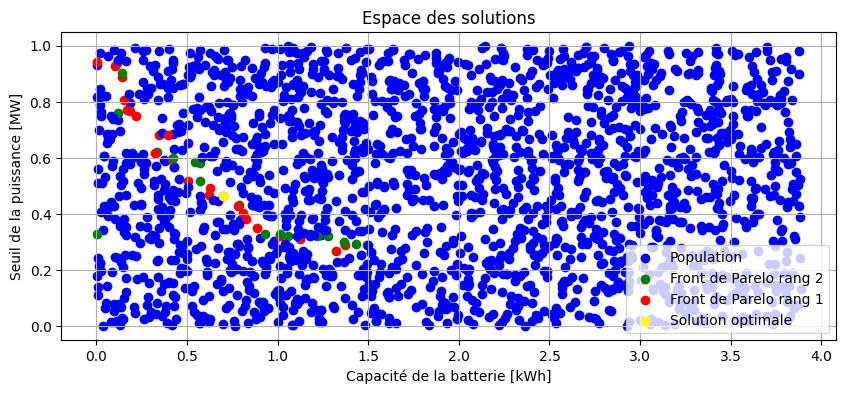

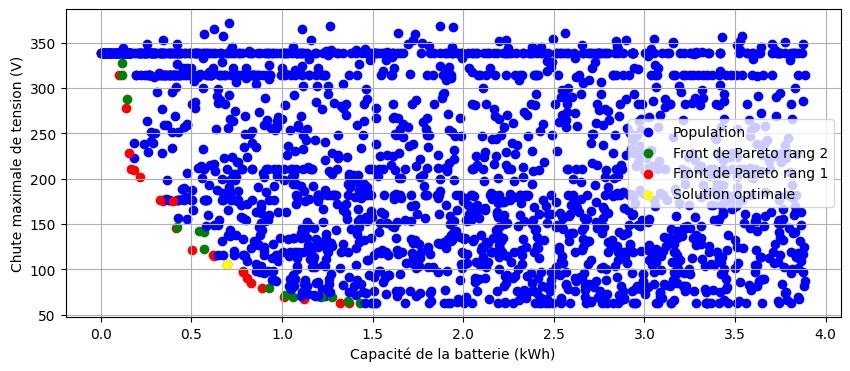

In [7]:
# **Fixer la graine pour générer les mêmes valeurs aléatoires**
np.random.seed(1)

# **Échantillonnage aléatoire des solutions possibles**
p_seuil = np.random.uniform(0, 1e6, 2000)  # Générer 2000 seuils de puissance aléatoires (en watts)
batt_capa = np.random.uniform(0, 14e6, 2000)  # Générer 2000 capacités de batterie aléatoires (en joules)

# Regrouper les solutions sous forme de tableaux [batt_capa, p_seuil]
solutions = [np.array([i, j]) for i, j in zip(batt_capa, p_seuil)]

# **Calcul de la chute de tension pour chaque solution**
chute_sys = []  # Liste pour stocker les chutes de tension maximales
for cap, s in zip(batt_capa, p_seuil):
    chute_max = simulation_sys(cap, s, Ptrain, Etrain, temps, Vsst, Req)  # Simuler le système
    chute_sys.append(chute_max)  # Ajouter la chute maximale à la liste

# **Extraction des fronts de Pareto jusqu'au rang 3**
rangs = pareto(batt_capa, chute_sys, 3)

# **Indice de la solution optimale (déterminée graphiquement)**
optimal = 1942

# **Affichage des résultats de Monte Carlo**
affichage_Monte_Carlo(batt_capa, rangs, p_seuil, optimal, chute_sys)

**Analyse des résultats:**
- En appliquant la méthode de Monte Carlo, le front de Pareto révèle une diminution rapide de la réduction de la chute de tension lorsque la capacité de la batterie augmente. 

- Cependant, au-delà d’une capacité de 1,3 kWh, ce gain se stabilise. 

- Une analyse plus approfondie a permis de visualiser un deuxième front,le point jaune représentant le meilleur compromis, correspond à une capacité de 0,7 kWh et à une puissance seuil de 463 kW. 


**Conclusion:**
- Le code fonctionne parfaitement et produit des résultats cohérents avec les attentes.

## 3.2.Optimisation bi-objectif avec NSGA-2

- L’optimisation bi-objectif avec NSGA utilise un algorithme génétique pour générer des solutions qui équilibrent deux critères, comme la capacité de la batterie et la chute de tension. Après un tri de Pareto, les meilleures solutions sont sélectionnées et croisées pour créer de nouvelles générations, jusqu’à obtenir un ensemble de solutions non dominées qui représentent un compromis optimal entre les deux objectifs.

--- Génération 1 ---


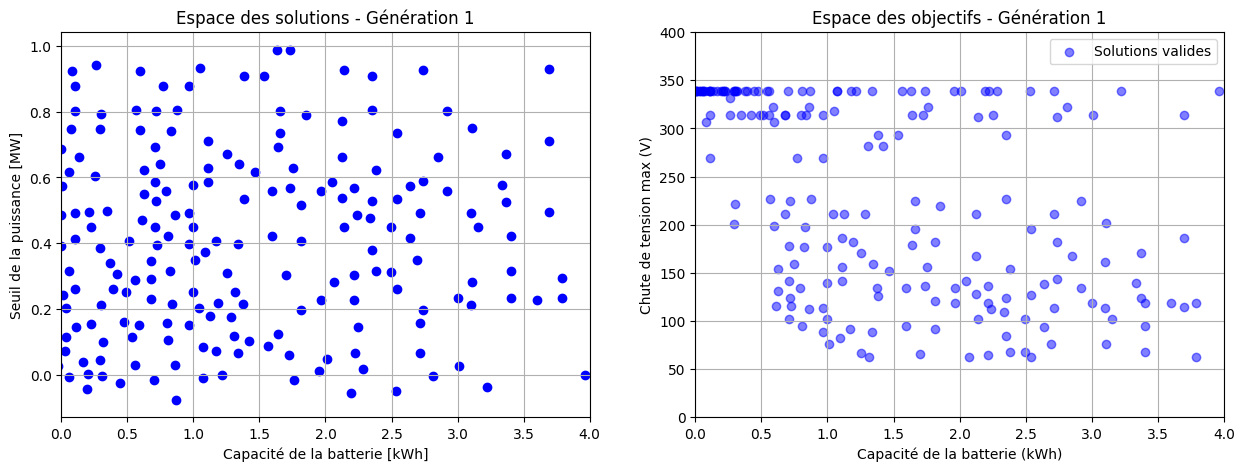

--- Génération 2 ---


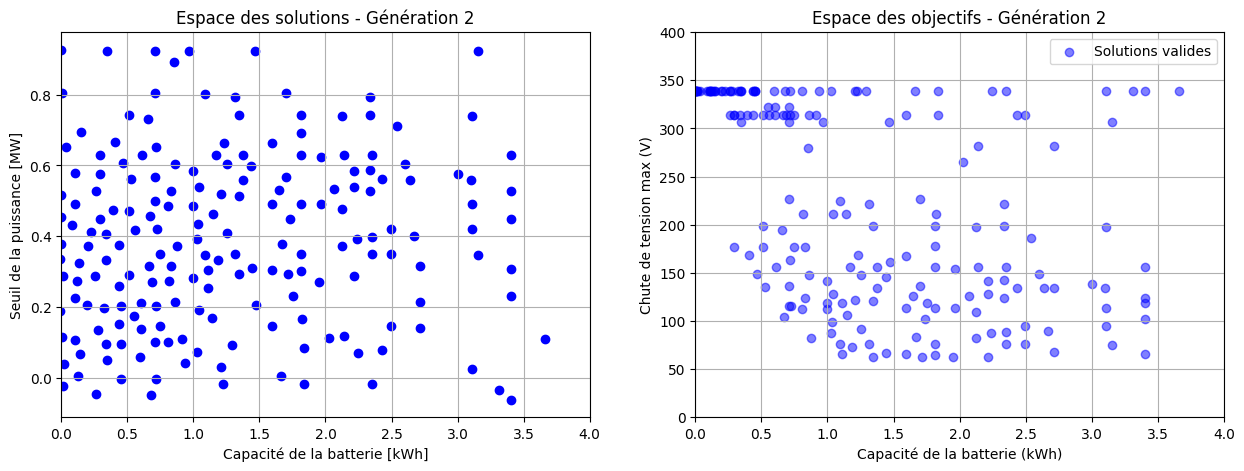

--- Génération 3 ---


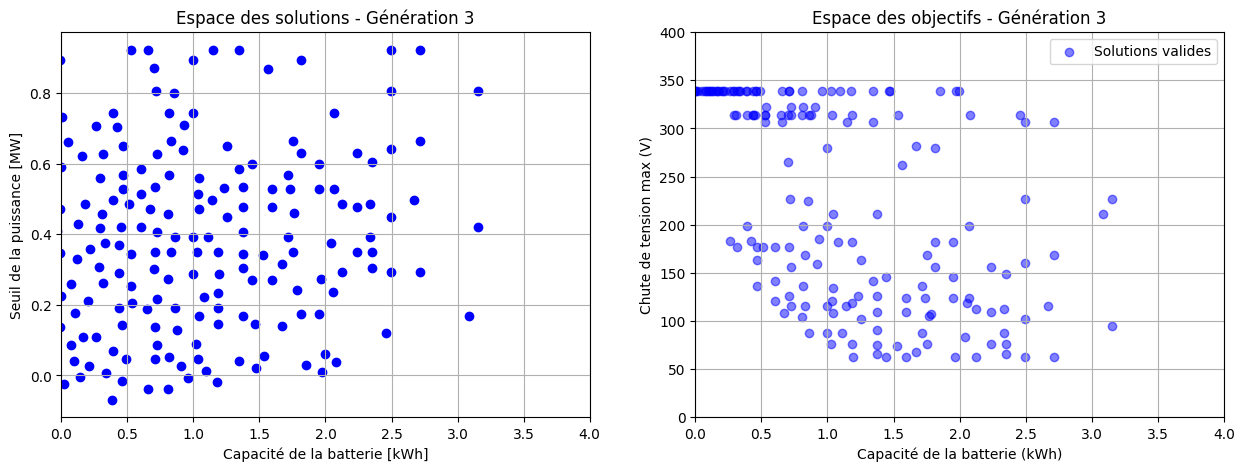

--- Génération 4 ---


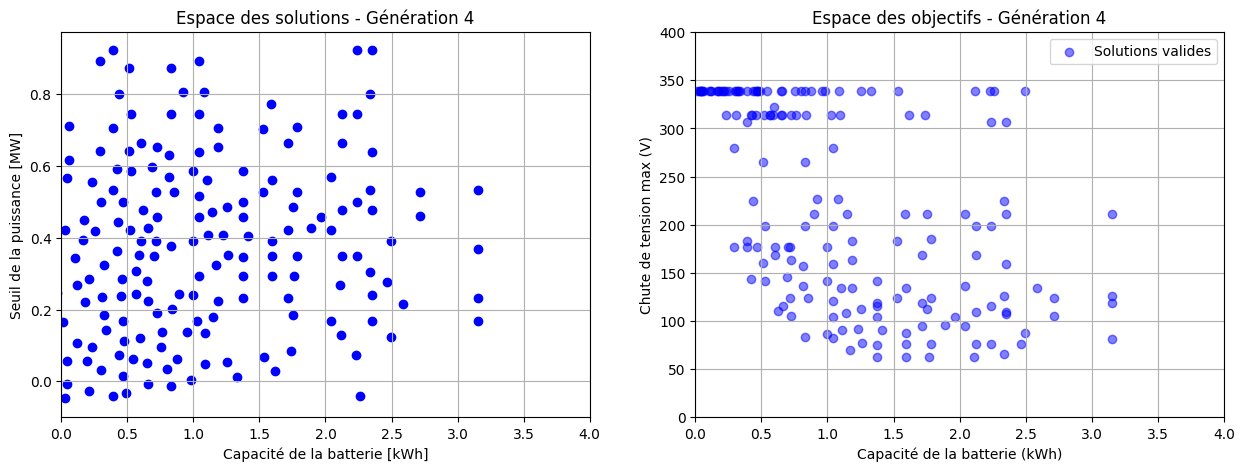

--- Génération 5 ---


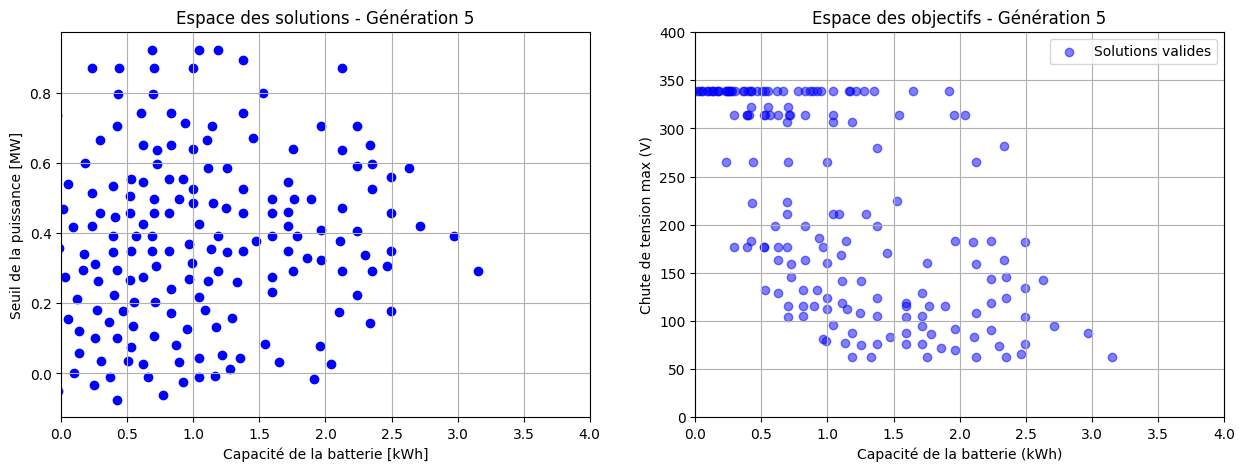

--- Génération 6 ---


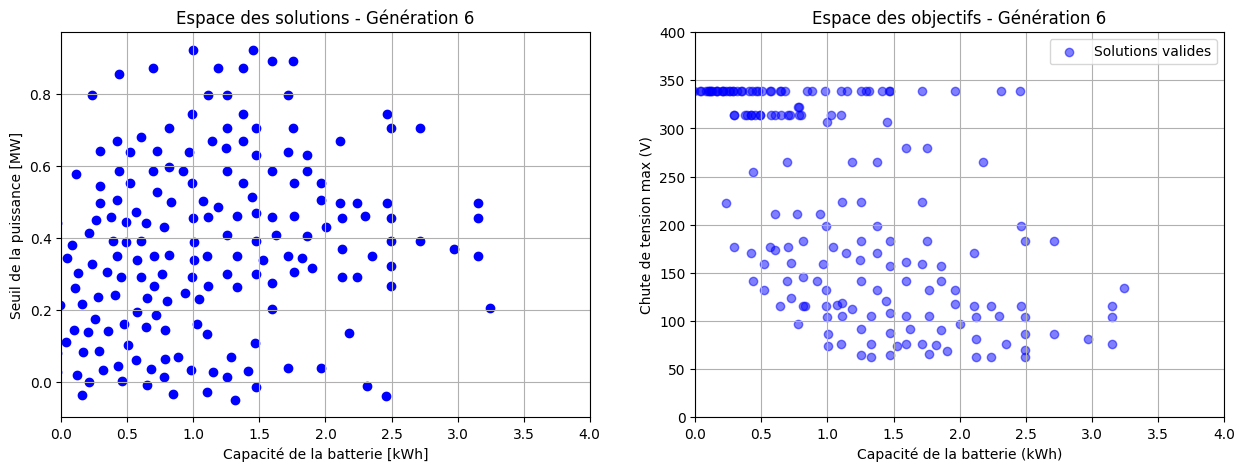

--- Génération 7 ---


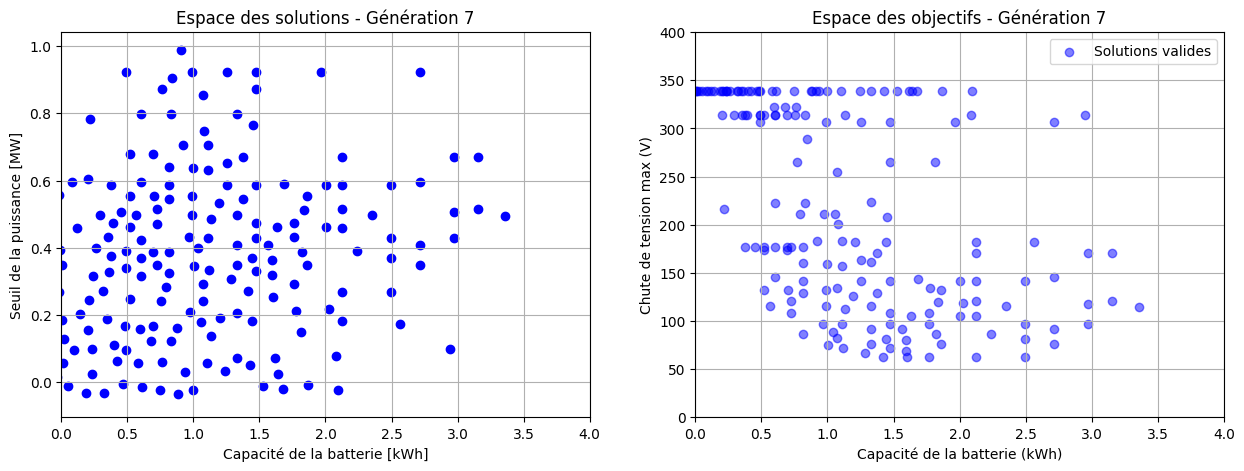

--- Génération 8 ---


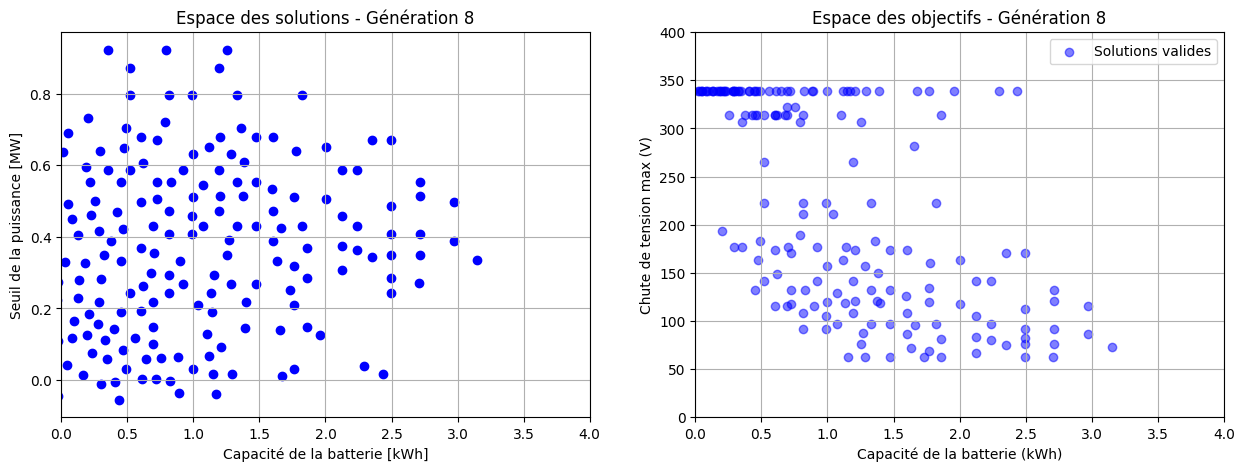

--- Génération 9 ---


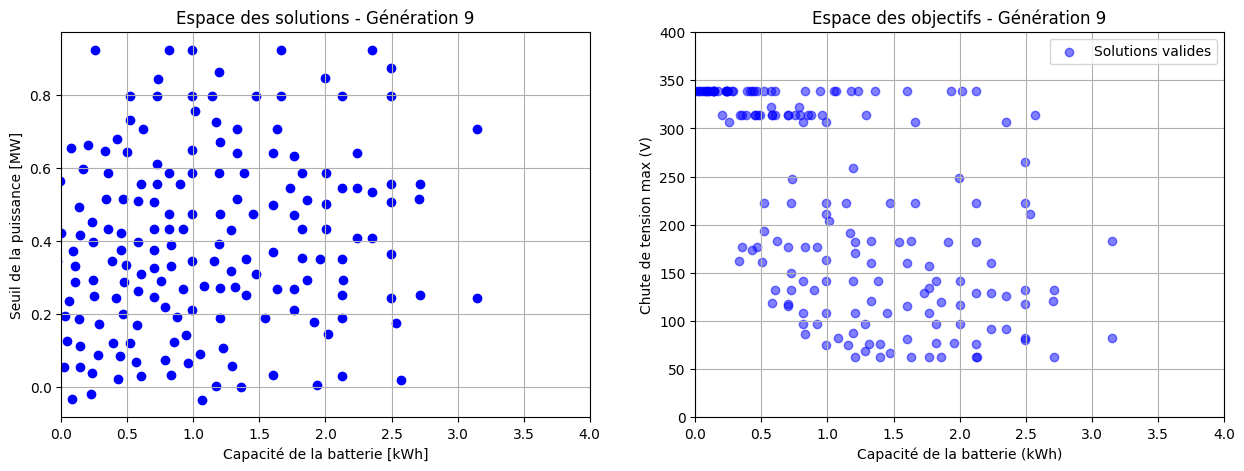

--- Génération 10 ---


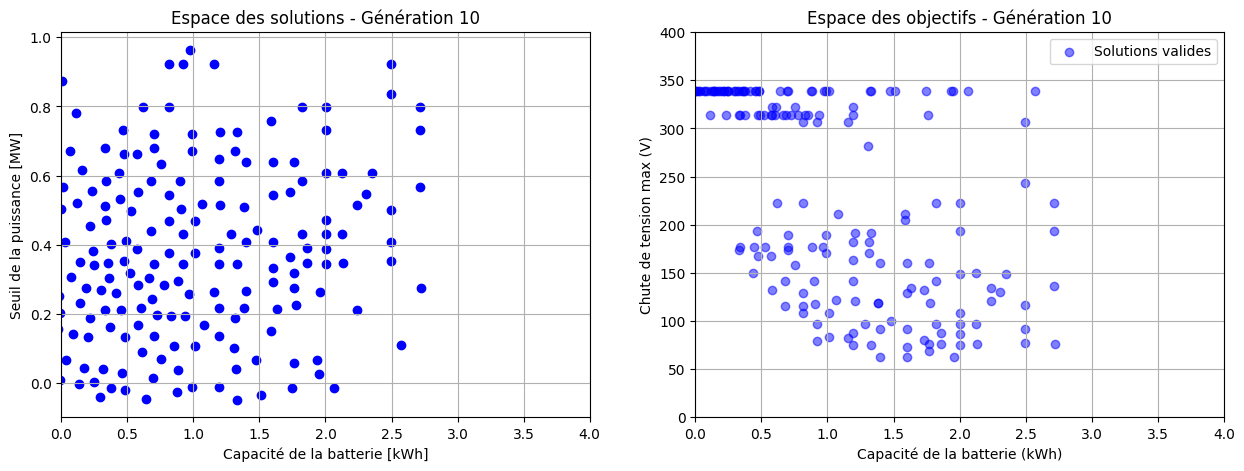

In [8]:
# **Paramètres de l'algorithme génétique**
N = 200  # Taille de la population initiale
G = 10   # Nombre de générations

# **Génération aléatoire des données initiales**
np.random.seed(1)  # Fixer une graine pour des résultats reproductibles
p_seuil = np.random.uniform(0, 1e6, N)  # Générer des seuils de puissance aléatoires
batt_capa = np.random.uniform(0, 14e6, N)  # Générer des capacités de batterie aléatoires

# **Calcul des chutes de tension pour la première génération**
chutte_max = np.array([
    simulation_sys(cap, s, Ptrain, Etrain, temps, Vsst, Req)
    for cap, s in zip(batt_capa, p_seuil)
])

# **Boucle sur les générations**
for generation in range(G):
    print(f"--- Génération {generation + 1} ---")
    
    # **Étape 1 : Appliquer l'algorithme génétique pour générer la prochaine génération**
    next_generation = algo_genetique(batt_capa, p_seuil, chutte_max, N)
    
    # **Étape 2 : Mettre à jour les capacités et seuils pour la prochaine génération**
    batt_capa = next_generation[:, 1]  # Nouvelles capacités de batterie
    p_seuil = next_generation[:, 0]    # Nouveaux seuils de puissance
    
    # **Étape 3 : Recalculer les chutes de tension pour la nouvelle génération**
    chutte_max = np.array([
        simulation_sys(cap, s, Ptrain, Etrain, temps, Vsst, Req)
        for cap, s in zip(batt_capa, p_seuil)
    ])

    # **Visualisation des résultats**
    plt.figure(figsize=(15, 5))
    
    # **Graphique 1 : Espace des solutions**
    plt.subplot(1, 2, 1)
    plt.scatter(batt_capa * 1e-3 / 3600, p_seuil * 1e-6, color='blue')
    plt.title(f"Espace des solutions - Génération {generation + 1}")
    plt.xlabel("Capacité de la batterie [kWh]")
    plt.ylabel("Seuil de la puissance [MW]")
    plt.xlim(0, 4)  # Limites en kWh
    plt.grid()

    # **Graphique 2 : Espace des objectifs**
    plt.subplot(1, 2, 2)
    plt.scatter(batt_capa * 1e-3 / 3600, chutte_max, alpha=0.5, label="Solutions valides", color='blue')
    plt.title(f"Espace des objectifs - Génération {generation + 1}")
    plt.xlabel("Capacité de la batterie (kWh)")
    plt.ylabel("Chute de tension max (V)")
    plt.legend()
    plt.ylim(0, 400)  # Limites en V
    plt.xlim(0, 4)  # Limites en kWh
    plt.grid(True)

    plt.show()


**Analyse des résultats :**
- L’algorithme NSGA-2 fonctionne, il identifie les solutions non dominées tout en maintenant une exploration suffisante de l’espace des solutions.
Après quelques générations, le front de Pareto est visible, et les compromis optimaux entre la capacité de batterie et chute de tension sont identifiables.

- En conclusion, nous pouvons observer qu’à partir de la septième génération, il n’y a plus de changement significatif dans les solutions obtenues. Cela indique qu’au-delà de ce point, le système atteint une forme de stabilité, où l’ajout de nouvelles génération n’affecte plus les résultats, suggérant ainsi que les solutions convergent vers une forme optimale.

**Remarque:**
- On remarque dans notre simulation un nuage de points, ce qui peut être expliqué par le caractère stochastique de l’algorithme.

### Comparaison entre les résultat de Monte-Carlo et NSGA-2:

- Les algorithmes génétiques sont souvent plus efficaces pour résoudre des problèmes complexes d’optimisation, car ils peuvent progressivement converger vers des solutions de meilleure qualité.

- La méthode de Monte Carlo, quant à elle, nécessite généralement un grand nombre d’évaluations pour obtenir des résultats aussi précis que ceux obtenus par des approches comme l'algorithmes génétiques. 

- Dans notre cas, les résultats de l'algorithme génétique ont été presque aussi performants qu'attendu, car on a bien pu visualiser le front de Pareto bien que l'algorithme n'ait pas convergé vers ce dernier.

## 4.Ajout d'une Troisième Sous-Station au Milieu de la Ligne

#### Contexte et Hypothèses
Dans le cadre de cette étude, nous analysons l'impact de l'ajout d'une troisième sous-station au milieu d'une ligne de tramway. Actuellement, la ligne est alimentée par deux sous-stations situées aux extrémités. L'objectif principal est de réduire les chutes de tension et d'améliorer la robustesse de l'alimentation électrique, en évitant que la tension du train descende en dessous du seuil critique de 500 V.

**Hypothèses de travail :**
1. La nouvelle sous-station est placée au milieu de la ligne.
2. Les paramètres des sous-stations restent constants (source de tension de 750 V avec une résistance interne de 33 mOhms).
3. Les résistances linéiques des lignes aériennes de contact (LAC) et des rails sont fixées à 95 μOhms/m et 10 μOhms/m respectivement.
4. Le profil de puissance du train reste identique à celui simulé précédemment.

#### Synthèse de l'Étude
L'ajout d'une troisième sous-station modifie le modèle électrique en introduisant un troisième chemin parallèle pour le flux électrique. Cela permet une meilleure répartition des charges entre les sous-stations et une réduction attendue des chutes de tension, notamment au milieu de la ligne où ces dernières sont généralement les plus critiques.

Cependant, en raison de contraintes de temps, nous n'avons pas pu finaliser cette analyse ni générer les résultats complets, tels que les graphiques des tensions ou les comparaisons entre les configurations avec et sans la troisième sous-station.

## 5.Conclusion Générale

Ce projet nous a permis de développer et de consolider des compétences essentielles dans plusieurs domaines. 

Nous avons appris à modéliser des systèmes physiques complexes, à appliquer des méthodes d'optimisation avancées comme les algorithmes génétiques et Monte Carlo, et à analyser des résultats de manière critique. 

Sur le plan méthodologique, nous avons renforcé notre capacité de raisonnement scientifique en validant des modèles par simulation, et en interprétant les résultats obtenus. 

Enfin, le projet a également mis en avant l'importance du travail en groupe, en nous permettant de collaborer efficacement, de répartir les tâches selon les compétences de chacun, et de produire une synthèse cohérente malgré les contraintes de temps. 

Ces apprentissages seront précieux dans notre parcours professionnel et académique.

